In [1]:
%load_ext ipycache

/home/zulissi/miniconda3/envs/cgcnn/lib/python3.7/site-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated since IPython 4.0. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)
/home/zulissi/miniconda3/envs/cgcnn/lib/python3.7/site-packages/ipycache.py:17: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils.traitlets import Unicode


In [2]:
import os
import sys
sys.path.insert(0,'../')
# sys.path.insert(0,'/home/zulissi/software/adamwr')
import numpy as np
#Select which GPU to use if necessary
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0
%env CUDA_LAUNCH_BLOCKING=1
# from torchviz import make_dot, make_dot_from_trace
import time
from torch.nn.utils import clip_grad_norm_
import pickle
import random
from torch.utils.data import Dataset, DataLoader
from cgcnn.data_grad import StructureData, ListDataset, StructureDataTransformer
import numpy as np
import tqdm
from sklearn.preprocessing import StandardScaler

import multiprocess as mp
from sklearn.model_selection import ShuffleSplit

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0
env: CUDA_LAUNCH_BLOCKING=1


In [3]:
# %%cache cached_docs.pkl docs SDT_list  orig_atom_fea_len nbr_fea_len
docs = pickle.load(open('../input/H_docs.pkl', 'rb'))

docs = [doc for doc in docs if doc['coordination']==doc['initial_coordination'] and doc['coordination']!=''
                               and doc['movement_data']['max_adsorbate_movement']<1.0
                               and doc['movement_data']['max_slab_movement']<0.2
                               and 'N' not in doc['atoms']['chemical_symbols'] #no nitrides
                               and 'C' not in doc['atoms']['chemical_symbols'] #no carbides
                               and 'S' not in doc['atoms']['chemical_symbols'] #no sulfides
                               and 'Se' not in doc['atoms']['chemical_symbols'] #no selenides
                               and doc['atoms']['symbol_counts']['H']<2 #no hydrides
        ]
random.shuffle(docs)
docs = docs[:]

start = time.time()

SDT = StructureDataTransformer(atom_init_loc='../atom_init.json',
                              max_num_nbr=12,
                               step= 0.5,
                              radius=12,
                              use_tag=True,
                               rattle=0.0,
                              use_fixed_info=True,
                              bond_property=True,
#                               use_voronoi=False,
#                               train_geometry = 'initial',
                              is_initial=True
                              )

SDT_out = SDT.transform(docs)

structures = SDT_out[0]

#Settings necessary to build the model (since they are size of vectors as inputs)
orig_atom_fea_len = structures[0].shape[-1]
nbr_fea_len = structures[1].shape[-1]


SDT_out = SDT.transform(docs)

with mp.Pool(4) as pool:
#     SDT_list = list(tqdm.tqdm(map(lambda x: SDT_out[x],range(len(SDT_out))),total=len(SDT_out)))
    SDT_list = list(tqdm.tqdm(pool.imap(lambda x: SDT_out[x],range(len(SDT_out)),chunksize=40),total=len(SDT_out)))

structures = SDT_list[0]
orig_atom_fea_len = structures[0].shape[-1]
nbr_fea_len = structures[1].shape[-1]


end = time.time()
SDT_time = end-start
print('SDT conversion time', SDT_time)
print('SDT list created')

100%|██████████| 4071/4071 [03:29<00:00, 19.42it/s] 

SDT conversion time 216.69766068458557
SDT list created


In [4]:
target_list = np.array([sdt[-1].numpy() for sdt in SDT_list]).reshape(-1,1)
# pickle.dump(SDT_list, open('./input/SDT_20000_grad.pkl', 'wb'))


In [5]:
from torch.optim import Adam, SGD
from sklearn.model_selection import ShuffleSplit
from skorch.callbacks import Checkpoint, LoadInitState #needs skorch 0.4.0, conda-forge version at 0.3.0 doesn't cut it

from cgcnn.data_grad import collate_pool, MergeDataset
from cgcnn.model_grad import CrystalGraphConvNet
from skorch import NeuralNetRegressor
import torch
import skorch.callbacks.base


cuda = torch.cuda.is_available()
if cuda:
    device = torch.device("cuda")
else:
    device='cpu'

#Make a checkpoint to save parameters every time there is a new best for validation lost
cp = Checkpoint(monitor='valid_loss_best',fn_prefix='valid_best_')

#Callback to load the checkpoint with the best validation loss at the end of training

class train_end_load_best_valid_loss(skorch.callbacks.base.Callback):
    def on_train_end(self, net, X, y):
        net.load_params('valid_best_params.pt')
        
load_best_valid_loss = train_end_load_best_valid_loss()
print('device', device)

device cuda


In [6]:
from sklearn.model_selection import train_test_split

SDT_list= SDT_list
target_list = target_list

indices = np.arange(len(SDT_list))
SDT_training, SDT_test, target_training, target_test, train_idx, test_idx \
= train_test_split(SDT_list, target_list, indices, test_size=0.2, random_state=42, shuffle=False)

# Benchmark for the validation set

We want to get an idea for what the DFT initial - final structure difference is; the ML models needs to beat this number for the validation set. 

In [7]:
def diff(target,sdt):
    free_atom_idx = list(set(list(range(len(target[0]))))-set(sdt[-2].numpy()))
    diff = np.sum(((target[0] - sdt[4].numpy())[free_atom_idx])**2.,axis=1)**0.5
#     diff = (target[0] - sdt[4].numpy())[free_atom_idx]

    return diff

np.mean(np.abs(np.concatenate([diff(target,sdt) for sdt,target in zip(SDT_test, target_test)])))

0.0842243

In [8]:
from skorch.dataset import CVSplit
from skorch.callbacks.lr_scheduler import WarmRestartLR, LRScheduler
from adamwr.adamw import AdamW
from torch.optim.lbfgs import LBFGS

from adamwr.cosine_scheduler import CosineLRWithRestarts
from sklearn.model_selection import train_test_split

train_test_splitter = ShuffleSplit(test_size=0.25, random_state=42)

batch_size=40

# warm restart scheduling from https://arxiv.org/pdf/1711.05101.pdf
LR_schedule = LRScheduler(CosineLRWithRestarts, batch_size=batch_size, epoch_size=len(SDT_training), restart_period=10, t_mult=1.2)


#############
# To extract intermediate features, set the forward takes only the first return value to calculate loss
class MyNet(NeuralNetRegressor):
    def get_loss(self, y_pred, y_true, **kwargs):        
#         pos_pred = y_pred[0] if isinstance(y_pred, tuple) else y_pred  # discard the 2nd output
        pos_pred = y_pred[0]
        additional_loss = y_pred[1]
        return torch.mean(torch.sqrt(torch.sum((pos_pred-y_true.cuda())**2.0,dim=1)))*10 
#         return super().get_loss(y_pred, y_true, **kwargs)
# return features = net.forward(SDT_test)
############

net = MyNet(
    CrystalGraphConvNet,
    module__orig_atom_fea_len = orig_atom_fea_len,
    module__nbr_fea_len = nbr_fea_len,
    batch_size=batch_size, #214
    module__classification=False,
    lr=0.0056,
    max_epochs= 1000, 
    module__atom_fea_len=46, #46,
    module__h_fea_len=83,
    module__n_conv=8, #8
    module__n_h=8,
        module__opt_step_size=0.3,
    module__min_opt_steps=20,
    module__max_opt_steps=300,
    module__step=0.5,
    module__dmax=12,
    optimizer__weight_decay=1e-3,
    optimizer=AdamW,
    iterator_train__pin_memory=True,
    iterator_train__num_workers=0,
    iterator_train__shuffle=True,
    iterator_train__collate_fn = collate_pool,
    iterator_valid__pin_memory=True,
    iterator_valid__num_workers=0,
    iterator_valid__collate_fn = collate_pool,
    device=device,
#     criterion=torch.nn.MSELoss,
    criterion=torch.nn.L1Loss,
    dataset=MergeDataset,
    train_split = CVSplit(cv=train_test_splitter),
    callbacks=[cp, LR_schedule, load_best_valid_loss] #    callbacks=[cp, load_best_valid_loss, LR_schedule]

)

In [19]:
net.initialize()
# net.module_.max_opt_steps=40
# net.max_epochs=400
# net.module_.update_spring=100
# net.module_.variable_bond_constant=False
# net.partial_fit(SDT_training, target_training)
net.module_.max_opt_steps=100
net.max_epochs=10
net.module_.update_spring=1000
net.module_.variable_bond_constant=False
net.partial_fit(SDT_training, target_training)
net.module_.max_opt_steps=100
net.max_epochs=100
net.module_.update_spring=1000
net.module_.variable_bond_constant=True
net.partial_fit(SDT_training, target_training)
# net.module_.max_opt_steps=100
# net.max_epochs=1000
# net.module_.update_spring=10
# net.module_.variable_bond_constant=True
# net.partial_fit(SDT_training, target_training)
# net.module_.max_opt_steps=50
# net.module_.max_epochs=100
# net.module_.update_spring=10
# net.partial_fit(SDT_training, target_training)
# net.module_.min_opt_steps=300
# net.module_.max_epochs=10
# net.partial_fit(SDT_training, target_training)


Re-initializing module because the following parameters were re-set: atom_fea_len, classification, dmax, h_fea_len, max_opt_steps, min_opt_steps, n_conv, n_h, nbr_fea_len, opt_step_size, orig_atom_fea_len, step.
Re-initializing optimizer because the following parameters were re-set: weight_decay.
  epoch    train_loss    valid_loss    cp      dur
-------  ------------  ------------  ----  -------
      1        1.7940        1.6691     +  30.7990
      2        0.9251        0.8597     +  23.0604
      3        0.8611        0.8245     +  21.8266
      4        0.8027        0.8045     +  22.1534
      5        0.7838        0.7751     +  22.6400
      6        0.7719        0.7647     +  22.5658
      7        0.7480        0.7610     +  22.7132
      8        0.7759        0.7591     +  22.9084
      9        0.7479        0.7625        23.0067
     10        0.7680        0.7572     +  22.7852
     11        0.7526        0.7757        49.5892
     12        0.7540        0.7664    

<class '__main__.MyNet'>[initialized](
  module_=CrystalGraphConvNet(
    (embedding): Linear(in_features=94, out_features=46, bias=True)
    (convs): ModuleList(
      (0): ConvLayer(
        (fc_full): Linear(in_features=117, out_features=92, bias=True)
        (sigmoid): Sigmoid()
        (softplus1): LeakyReLU(negative_slope=0.01)
        (bn1): BatchNorm1d(92, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn2): BatchNorm1d(46, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (softplus2): LeakyReLU(negative_slope=0.01)
      )
      (1): ConvLayer(
        (fc_full): Linear(in_features=117, out_features=92, bias=True)
        (sigmoid): Sigmoid()
        (softplus1): LeakyReLU(negative_slope=0.01)
        (bn1): BatchNorm1d(92, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn2): BatchNorm1d(46, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (softplus2): LeakyReLU(negative_slope=0.0

In [20]:
import ase.io
import mongo
mean_error_ml = []
mean_error_dft = []
net.load_params('valid_best_params.pt')

with ase.io.trajectory.TrajectoryWriter('test.traj') as traj:
    for i, (doc, sdt) in enumerate(zip(np.array(docs)[test_idx], SDT_test)):
        atoms_final = mongo.make_atoms_from_doc(doc)
        final_pos = sdt[-1]
        atoms_final.positions=final_pos
        atoms_init = mongo.make_atoms_from_doc(doc['initial_configuration'])
        ml_pos = list(net.forward_iter([sdt]))[0][-1].detach().numpy()
        atoms_ml = atoms_final.copy()
        atoms_ml.positions = ml_pos
        traj.write(atoms_init)
        traj.write(atoms_ml)
        traj.write(atoms_final)
        diff = np.abs(np.sqrt(np.sum((ml_pos-final_pos.numpy())**2.,axis=1)))
#         diff = diff[diff>1e-6]
        
        free_indices = list(set(range(len(atoms_final)))-set(atoms_final.constraints[0].get_indices()))
        diff = diff[free_indices]
        
        mean_error_ml.append(diff)
        
        diff = np.abs(np.sqrt(np.sum((atoms_init.positions-final_pos.numpy())**2.,axis=1)))
        diff = diff[free_indices]
        #diff = diff[diff>1e-6]
        mean_error_dft.append(np.abs(diff))

mean_error_ml = np.array(mean_error_ml)

In [11]:
diff

array([0.00699114, 0.02874953, 0.02458825, 0.00727477, 0.01343165,
       0.01303214, 0.01296901, 0.01335833, 0.1508423 ])

In [12]:
124*3

372

In [13]:
np.argsort([np.mean(a) for a in mean_error_ml])

array([387,  58, 763, 663, 488, 134, 221,  51, 476, 337, 604, 233, 680,
       719, 142, 294, 696, 751, 814, 413, 512, 644, 760, 179, 211, 242,
       772, 463, 234, 202, 588, 560, 110, 753,  56, 721,  74, 264,  71,
       163, 666, 339,  41, 305, 426, 114, 653, 407,  96, 460,  17, 489,
       188, 728, 225, 236, 771, 373,  66, 768, 541, 693, 516, 219,  99,
       213, 701, 218, 673, 639, 143, 674, 440, 164, 678, 399, 120, 809,
       565, 333, 623, 408, 465, 425, 734,  69,  98, 608, 749,  65, 527,
       246, 549, 137, 567, 583, 713, 168, 435, 543, 104, 403,  37, 232,
        87, 276, 102, 184, 295, 506, 646, 661, 535, 479, 759, 794, 365,
        62, 171, 450, 609,   2, 722, 752,  23, 343, 124, 438, 473, 411,
       540, 203, 566, 625,  49, 453, 544, 594,  29, 345, 240, 227, 158,
       584, 216, 138, 791, 804, 743, 384, 368,  35, 351, 747, 297,  54,
       378, 611, 322,   1, 350, 393, 359, 429, 769, 358, 554, 485, 132,
         7,  95, 421, 430, 546, 746, 707, 483, 291,  85,   0, 35

In [14]:
sorted([np.mean(a) for a in mean_error_ml])

[0.010505209,
 0.012501226,
 0.013323843,
 0.021876266,
 0.023562385,
 0.026124582,
 0.026549827,
 0.027632609,
 0.02771201,
 0.027791156,
 0.027810656,
 0.027891183,
 0.027954396,
 0.027956123,
 0.028427042,
 0.029174507,
 0.029490754,
 0.030021798,
 0.03013756,
 0.030419713,
 0.030927833,
 0.031121887,
 0.031503823,
 0.031510875,
 0.031827495,
 0.032050446,
 0.03219772,
 0.032501884,
 0.032531083,
 0.032778922,
 0.03298989,
 0.03476367,
 0.035927042,
 0.036295604,
 0.036836136,
 0.037446383,
 0.037715245,
 0.03782248,
 0.037954744,
 0.03817786,
 0.038178813,
 0.038433716,
 0.03846635,
 0.038613856,
 0.0394441,
 0.03947965,
 0.03979223,
 0.039926358,
 0.040320847,
 0.04079526,
 0.040944234,
 0.04101831,
 0.041208692,
 0.041290663,
 0.041390333,
 0.04188499,
 0.04191116,
 0.042026557,
 0.04206192,
 0.042127833,
 0.04257621,
 0.04257992,
 0.042684853,
 0.042882875,
 0.042990677,
 0.043232314,
 0.043687746,
 0.043780442,
 0.043791424,
 0.043942742,
 0.04396769,
 0.044022888,
 0.04438492,

In [15]:
import matplotlib.pyplot as plt
plt.hist([np.mean(a) for a in mean_error_ml])

(array([100., 311., 249., 103.,  39.,   7.,   5.,   0.,   0.,   1.]),
 array([0.01050521, 0.04795045, 0.08539569, 0.12284094, 0.16028619,
        0.19773142, 0.23517667, 0.2726219 , 0.31006715, 0.3475124 ,
        0.38495764], dtype=float32),
 <a list of 10 Patch objects>)

(array([100., 310., 250., 103.,  39.,   7.,   5.,   0.,   0.,   1.]),
 array([0.01049461, 0.04795014, 0.08540567, 0.1228612 , 0.16031672,
        0.19777225, 0.23522778, 0.27268331, 0.31013883, 0.34759436,
        0.38504989]),
 <a list of 10 Patch objects>)

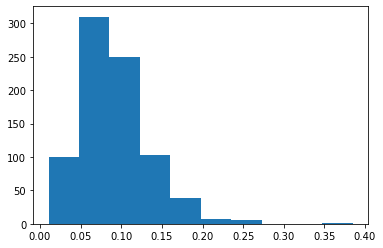

In [16]:
plt.hist([np.mean(a) for a in mean_error_dft])

In [17]:
447*3

1341

In [18]:
np.mean(mean_error_ml)

ValueError: operands could not be broadcast together with shapes (25,) (17,) 

In [ ]:
diff.shape